# Agent-Based Model of Cancer Stem Cell (CSC) Driven Tumor Growth

This Jupyter notebook implements a 2D agent-based model (ABM) of tumor growth driven by cancer stem cells (CSC) and progenitor/differentiated cells (PC). It includes three requested extensions:

1. **Therapy pulse** (increased death rates during a time window).
2. **Nutrient diffusion PDE** that modulates division rates.
3. **Asynchronous Gillespie-style event simulation** (next-event sampling) and GIF creation of lattice snapshots.

The notebook is organized as follows:

* Introduction and model description (markdown)
* Parameters and imports (code)
* Helper functions (code)
* Gillespie ABM + nutrient PDE + therapy (code)
* GIF creation and visualization (code)
* Suggested experiments and extension ideas (markdown)

---

## How to use

* Run the notebook cell-by-cell in order. The main simulation may take a minute or more depending on grid size and `t_max`.
* The GIF will be saved to `/mnt/data/tumor_dynamics.gif` (or the path you set in the parameters cell). Download it from that path after running.
* If your environment lacks `imageio`, install it: `pip install imageio`.


## 1) Imports and Parameters
Run this cell first to set up parameters and imports.

In [12]:
# Imports
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import tempfile, os, time as pytime

# Optional: If imageio is not installed, uncomment the next line
# !pip install imageio
import imageio

# ---------------------
# PARAMETERS (edit here)
# ---------------------
Lx, Ly = 120, 120            # lattice size
seed = 1234
np.random.seed(seed)
random.seed(seed)

# Cell types
EMPTY, CSC, PC = 0, 1, 2

# Base rates (per time unit, used by Gillespie)
rate_div_CSC = 0.12
rate_div_PC = 0.20
rate_death_CSC = 0.002
rate_death_PC = 0.01
rate_move = 0.04

# CSC division outcomes
p_sym_self = 0.12    # symmetric self-renewal -> 2 CSC
p_sym_diff = 0.04    # symmetric differentiation -> 2 PC
# remainder -> asymmetric (1 CSC + 1 PC)

pc_max_divisions = 3  # replicative capacity of progenitor cells

# Nutrient PDE parameters
use_nutrient = True
D = 1.0
decay = 0.01
uptake = 0.02
nutrient_source = 1.0
nutrient_dt = 0.4

# Therapy pulse parameters
use_therapy = True
therapy_start = 10.0
therapy_end = 18.0
therapy_fold_increase_PC_death = 20.0
therapy_fold_increase_CSC_death = 5.0

# Simulation controls
t_max = 200.0
frames_count = 40
snapshot_times = np.linspace(0, t_max, frames_count)

# Output
out_gif = 'output/tumor_dynamics.gif'

# ---------------------
# Derived / bookkeeping
# ---------------------
nbrs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]  # Moore neighborhood

# Initialize lattice
cell_type = np.zeros((Lx, Ly), dtype=np.int8)
pc_div_left = np.zeros((Lx, Ly), dtype=np.int8)

# place initial CSC in center
cx, cy = Lx//2, Ly//2
cell_type[cx, cy] = CSC
pc_div_left[:] = 0

# nutrient field
if use_nutrient:
    nutrient = np.ones((Lx, Ly)) * nutrient_source
else:
    nutrient = None

# temp frames directory
tempdir = tempfile.mkdtemp()
frames = []
frame_idx = 0

print('Parameters set. Lattice size:', Lx, 'x', Ly)

Parameters set. Lattice size: 120 x 120



## 2) Helper functions
Contains neighborhood lookups, nutrient PDE step, propensity computation, and frame capture.

In [13]:
# Helper functions

def in_bounds(x, y):
    return 0 <= x < Lx and 0 <= y < Ly


def get_empty_neighbors(x, y):
    coords = []
    for dx, dy in nbrs:
        nx, ny = x + dx, y + dy
        if in_bounds(nx, ny) and cell_type[nx, ny] == EMPTY:
            coords.append((nx, ny))
    return coords


def nutrient_step(nutrient_field, dt):
    """Explicit finite-difference diffusion + decay + uptake. Dirichlet boundary at nutrient_source."""
    new = nutrient_field.copy()
    lap = np.zeros_like(nutrient_field)
    # 5-point laplacian on interior
    lap[1:-1, 1:-1] = (
        nutrient_field[2:, 1:-1]
        + nutrient_field[:-2, 1:-1]
        + nutrient_field[1:-1, 2:]
        + nutrient_field[1:-1, :-2]
        - 4 * nutrient_field[1:-1, 1:-1]
    )
    uptake_field = np.zeros_like(nutrient_field)
    uptake_field[cell_type != EMPTY] = uptake
    new += dt * (D * lap - decay * nutrient_field - uptake_field)
    # enforce Dirichlet at boundaries
    new[0, :] = nutrient_source
    new[-1, :] = nutrient_source
    new[:, 0] = nutrient_source
    new[:, -1] = nutrient_source
    new[new < 0] = 0.0
    return new


def compute_propensities(current_time):
    """Build events and rates lists for Gillespie sampling."""
    events = []
    rates = []
    # therapy-modified death rates
    if use_therapy and therapy_start <= current_time <= therapy_end:
        rd_pc = rate_death_PC * therapy_fold_increase_PC_death
        rd_csc = rate_death_CSC * therapy_fold_increase_CSC_death
    else:
        rd_pc = rate_death_PC
        rd_csc = rate_death_CSC

    xs, ys = np.nonzero(cell_type != EMPTY)
    for x, y in zip(xs, ys):
        c = cell_type[x, y]
        # nutrient factor (saturating)
        if use_nutrient:
            local_n = nutrient[x, y]
            nut_factor = local_n / (0.5 + local_n)
        else:
            nut_factor = 1.0

        if c == CSC:
            rdiv = rate_div_CSC * nut_factor
            rdeath = rd_csc
            rmove = rate_move
            if get_empty_neighbors(x, y):
                events.append(('div', x, y)); rates.append(rdiv)
                events.append(('move', x, y)); rates.append(rmove)
            events.append(('death', x, y)); rates.append(rdeath)

        elif c == PC:
            rdiv = rate_div_PC * nut_factor if pc_div_left[x, y] > 0 else 0.0
            rdeath = rd_pc
            rmove = rate_move * 0.5
            if get_empty_neighbors(x, y) and rdiv > 0:
                events.append(('div', x, y)); rates.append(rdiv)
                events.append(('move', x, y)); rates.append(rmove)
            events.append(('death', x, y)); rates.append(rdeath)

    if not rates:
        return [], [], 0.0
    rates = np.array(rates, dtype=float)
    total_rate = rates.sum()
    return events, rates, total_rate


def capture_frame(t):
    """Create and save a small image frame of the lattice for GIF."""
    global frame_idx
    cmap = colors.ListedColormap(['white', 'red', 'blue'])
    bounds = [0, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(cell_type.T, origin='lower', cmap=cmap, norm=norm)
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(2, 2, f"t={t:.2f}", color='black', bbox=dict(facecolor='white', alpha=0.6), fontsize=8)
    fname = os.path.join(tempdir, f"frame_{frame_idx:04d}.png")
    fig.savefig(fname, dpi=100)
    plt.close(fig)
    frames.append(fname)
    frame_idx += 1

print('Helper functions loaded.')

Helper functions loaded.


## 3) Gillespie ABM main loop
Run this cell to perform the event-driven simulation. It will capture frames at times in `snapshot_times` and produce a GIF saved to `out_gif`.

**Note:** The simulation recomputes propensities before each event (simple but potentially slow). For larger runs consider optimizing by updating only the affected local propensities.


In [14]:
# Initialize pc_div_left for any existing PCs (none at start)
pc_div_left[cell_type == PC] = pc_max_divisions

# Main Gillespie loop
t = 0.0
next_snapshot_idx = 0
capture_frame(0.0)

event_count = 0
max_events = 2_000_000
start_wall = pytime.time()

while t < t_max and event_count < max_events:
    events, rates, total_rate = compute_propensities(t)
    if total_rate <= 0 or len(rates) == 0:
        print('No events available, stopping simulation at t=', t)
        break
    u = np.random.rand()
    dt = -math.log(u) / total_rate
    t += dt
    # advance nutrient field in smaller substeps
    if use_nutrient:
        num_steps = max(1, int(math.ceil(dt / nutrient_dt)))
        small_dt = dt / num_steps
        for _ in range(num_steps):
            nutrient = nutrient_step(nutrient, small_dt)
    # choose event
    probs = rates / rates.sum()
    idx = np.random.choice(len(events), p=probs)
    ev = events[idx]
    # Handle event
    if ev[0] == 'death':
        _, x, y = ev
        if cell_type[x, y] != EMPTY:
            cell_type[x, y] = EMPTY
            pc_div_left[x, y] = 0
    elif ev[0] == 'move':
        _, x, y = ev
        if cell_type[x, y] != EMPTY:
            empty_nb = get_empty_neighbors(x, y)
            if empty_nb:
                nx, ny = random.choice(empty_nb)
                cell_type[nx, ny] = cell_type[x, y]
                pc_div_left[nx, ny] = pc_div_left[x, y]
                cell_type[x, y] = EMPTY
                pc_div_left[x, y] = 0
    elif ev[0] == 'div':
        _, x, y = ev
        if cell_type[x, y] == EMPTY:
            pass
        else:
            empty_nb = get_empty_neighbors(x, y)
            if not empty_nb:
                pass
            else:
                nx, ny = random.choice(empty_nb)
                if cell_type[x, y] == CSC:
                    rdraw = np.random.rand()
                    if rdraw < p_sym_self:
                        # daughter CSC
                        cell_type[nx, ny] = CSC
                        pc_div_left[nx, ny] = 0
                    elif rdraw < p_sym_self + p_sym_diff:
                        # symmetric differentiation -> both PCs
                        cell_type[nx, ny] = PC
                        pc_div_left[nx, ny] = pc_max_divisions - 1
                        cell_type[x, y] = PC
                        pc_div_left[x, y] = pc_max_divisions - 1
                    else:
                        # asymmetric -> parent CSC + daughter PC
                        cell_type[nx, ny] = PC
                        pc_div_left[nx, ny] = pc_max_divisions - 1
                elif cell_type[x, y] == PC:
                    if pc_div_left[x, y] > 0:
                        cell_type[nx, ny] = PC
                        pc_div_left[nx, ny] = pc_div_left[x, y] - 1
                        pc_div_left[x, y] = pc_div_left[x, y] - 1
    event_count += 1
    # capture frames at scheduled snapshot times
    if next_snapshot_idx < len(snapshot_times) and t >= snapshot_times[next_snapshot_idx]:
        capture_frame(t)
        next_snapshot_idx += 1

# final frame
capture_frame(t)
end_wall = pytime.time()
print('Simulation finished: t_final=', t, 'events=', event_count, 'wall_time(s)=', end_wall - start_wall)

# Save GIF
images = [imageio.imread(fname) for fname in frames]
imageio.mimsave(out_gif, images, duration=0.15)
print('Saved GIF to:', out_gif)

Simulation finished: t_final= 200.7995784844362 events= 221 wall_time(s)= 1.98260498046875


/tmp/ipykernel_40649/2801588318.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fname) for fname in frames]


Saved GIF to: output/tumor_dynamics.gif


## 4) Visualization and quick diagnostics
This cell plots the final lattice and basic population counts.


Final counts: total= 64 CSC= 2 PC= 62


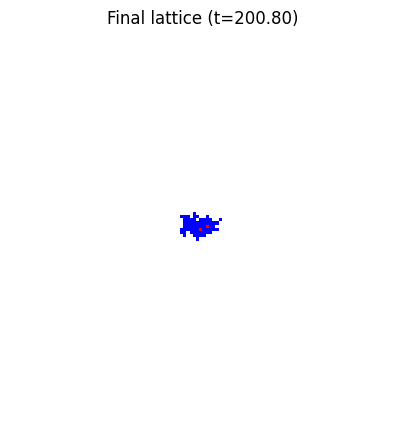

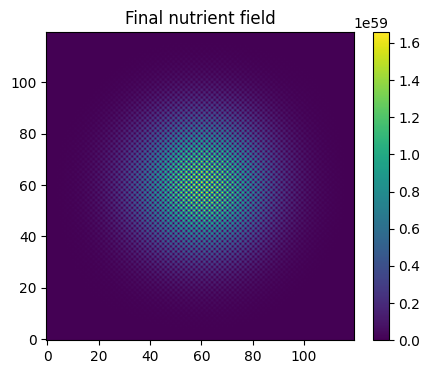


GIF available at: output/tumor_dynamics.gif


In [15]:
# final counts and quick plots
total = np.count_nonzero(cell_type != EMPTY)
n_csc = np.count_nonzero(cell_type == CSC)
n_pc = np.count_nonzero(cell_type == PC)
print('Final counts: total=', total, 'CSC=', n_csc, 'PC=', n_pc)

# Show final lattice
plt.figure(figsize=(5,5))
cmap = colors.ListedColormap(['white', 'red', 'blue'])
plt.imshow(cell_type.T, origin='lower', cmap=cmap)
plt.title(f'Final lattice (t={t:.2f})')
plt.axis('off')
plt.show()

# Show nutrient heatmap if used
if use_nutrient:
    plt.figure(figsize=(5,4))
    plt.imshow(nutrient.T, origin='lower')
    plt.title('Final nutrient field')
    plt.colorbar(); plt.show()

# Provide GIF path
print('\nGIF available at:', out_gif)


## 5) Suggested experiments
- Vary `p_sym_self` (symmetric self-renewal probability) and show CSC fraction & tumor growth differences.
- Simulate a stronger/longer therapy pulse and show tumor relapse dynamics.
- Compare runs with `use_nutrient=True` vs `False` to highlight the role of microenvironment.
- Increase lattice size and `t_max` for smoother dynamics (but expect longer runtimes).

## 6) Extensions and optimization ideas
- Replace naive propensity recomputation by maintaining an event list and updating local propensities only when neighbouring sites change.
- Implement pushing mechanics for division into crowded neighborhoods.
- Couple with oxygen diffusion and hypoxia-driven phenotypic switching.
- Export and animate as higher-resolution MP4 using `matplotlib.animation`.

---